# Sample Notebook for the Data Analytics Hackathon

* The notebook that you submit **must** run (without *any* errors), and create a `submission.csv` file, in the required format.

* This notebook should serve as a template to your final notebook submission.

In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed

# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ue21cs342aa2/sample_submission.csv
/kaggle/input/ue21cs342aa2/train.csv
/kaggle/input/ue21cs342aa2/test.csv


`index_col` helps you to retain the index as provided in the dataset.

In [39]:
train = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv", index_col = 0)
test = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv", index_col = 0)

In [40]:
train.head()

,Date,Open,Close,Volume,Strategy
id,,,,,
0,2015-06-01,66.208486,75.609978,298506300,Hold
1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2015-06-15,47.701942,71.140831,250670900,Buy
3,2015-06-22,54.754816,72.881344,223614300,Hold
4,2015-06-29,48.031899,66.284718,406814900,Buy


In [41]:
train.tail()

,Date,Open,Close,Volume,Strategy
id,,,,,
295,2021-01-25,81.284821,83.373498,117281600,Sell
296,2021-02-01,71.970249,85.294903,177655800,Sell
297,2021-02-08,71.784627,83.266453,146003500,Hold
298,2021-02-15,69.372333,81.026827,167762500,Hold
299,2021-02-22,69.618620,78.672007,332979200,Hold


In [42]:
test.head()

,Date,Open,Volume
id,,,
0,2021-03-01,72.708331,205897600
1,2021-03-08,73.310886,214095600
2,2021-03-15,70.610119,151601700
3,2021-03-22,70.256017,193982500
4,2021-03-29,68.258324,220238400


In [43]:
test.tail()

,Date,Open,Volume
id,,,
95,2022-12-26,57.048622,224994700
96,2023-01-02,60.569661,176020500
97,2023-01-09,61.446777,181478600
98,2023-01-16,55.447711,162471700
99,2023-01-23,57.008939,178924000


<Axes: xlabel='id'>

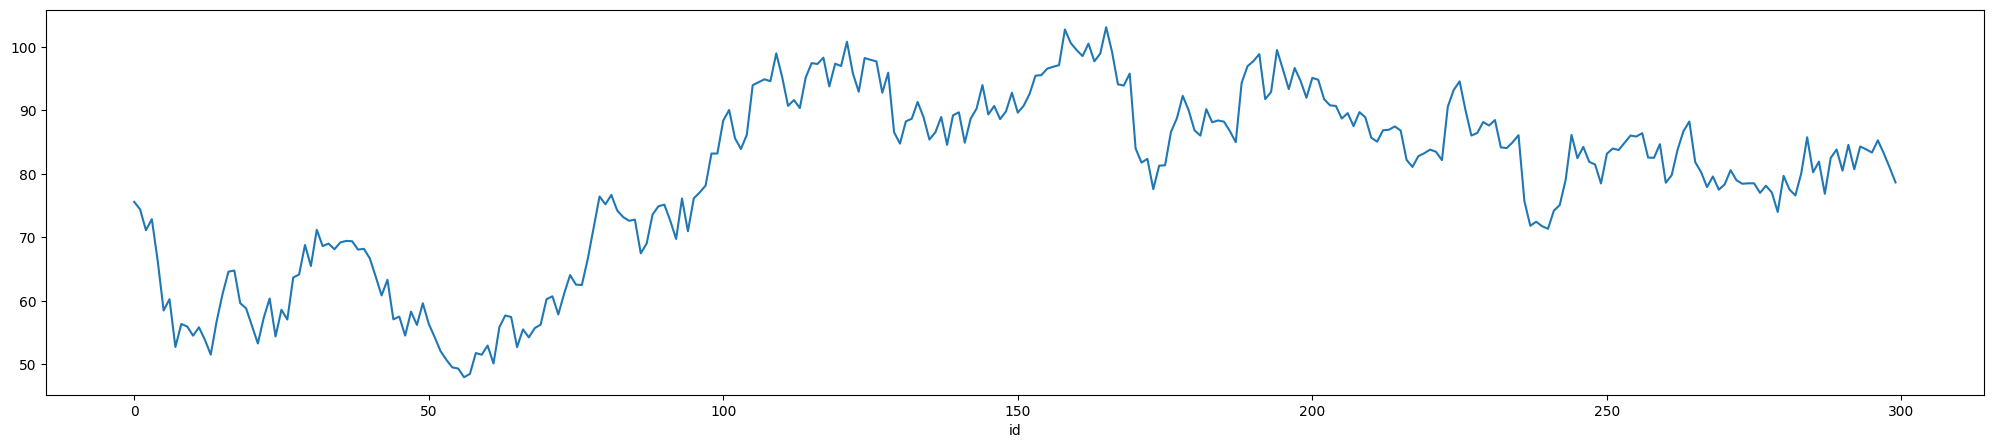

In [44]:
train['Close'].plot(figsize=(25,5))

<Axes: xlabel='id'>

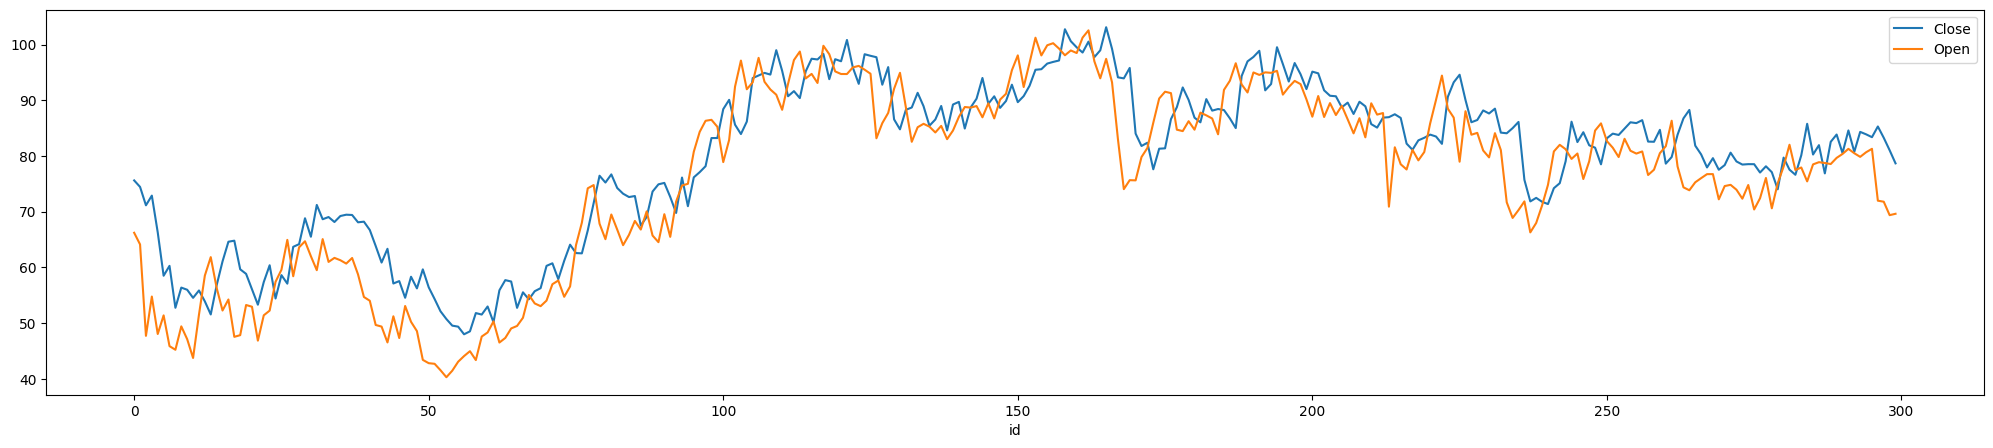

In [45]:
train[['Close', 'Open']].plot(figsize=(25, 5))

# **Augmented Dickey-Fuller Test**

In [46]:
t = sm.tsa.adfuller(train.Close, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -1.808006
p-value                          0.376494
#Lags Used                       1.000000
Number of Observations Used    298.000000
dtype: float64

We can see that  𝑝>0.05
 , hence the data is not stationary. We need to implement some sort of differencing to make the data stationary.

In [47]:
train['differenced_values'] = train['Close'].diff(1)
train.dropna(inplace=True)
train['logVolume'] = np.log(train['Volume'])
test['logVolume'] = np.log(test['Volume'])

In [48]:
# added features
# train['Close-squared'] = np.array(train['Close']) ** 2
train['SMA_4'] = train['Close'].rolling(window=4).mean()
train['SMA_12'] = train['Close'].rolling(window=12).mean()

train['Close_Lag_1'] = train['Close'].shift(1)
train['Close_Lag_2'] = train['Close'].shift(2)

train['Volatility_4'] = train['Close'].rolling(window=4).std()

delta = train['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=12).mean()
average_loss = loss.rolling(window=12).mean()
rs = average_gain / average_loss
rsi = 100 - (100 / (1 + rs))
train['RSI'] = rsi

short_ema = train['Close'].ewm(span=12, adjust=False).mean()
long_ema = train['Close'].ewm(span=24, adjust=False).mean()
train['MACD'] = short_ema - long_ema

train['Upper_Band'] = train['SMA_12'] + (2 * train['Close'].rolling(window=12).std())
train['Lower_Band'] = train['SMA_12'] - (2 * train['Close'].rolling(window=12).std())

train['Close_vs_SMA_4'] = train['Close'] / train['SMA_4']
train['Close_vs_SMA_12'] = train['Close'] / train['SMA_12']

train['Price_RoC_4'] = train['Close'].pct_change(periods=4)
train['Price_RoC_12'] = train['Close'].pct_change(periods=12)

train['Open_Close_Corr'] = train['Open'].rolling(window=10).corr(train['Close'])

In [49]:
t = sm.tsa.adfuller(train.differenced_values, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                 -19.615948
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    298.000000
dtype: float64

Single order differencing seems to work here! We can see that  𝑝<0.05
  now

# Decomposition of elements

In [50]:
s = sm.tsa.seasonal_decompose(train.Close, period=12)

<Axes: xlabel='id'>

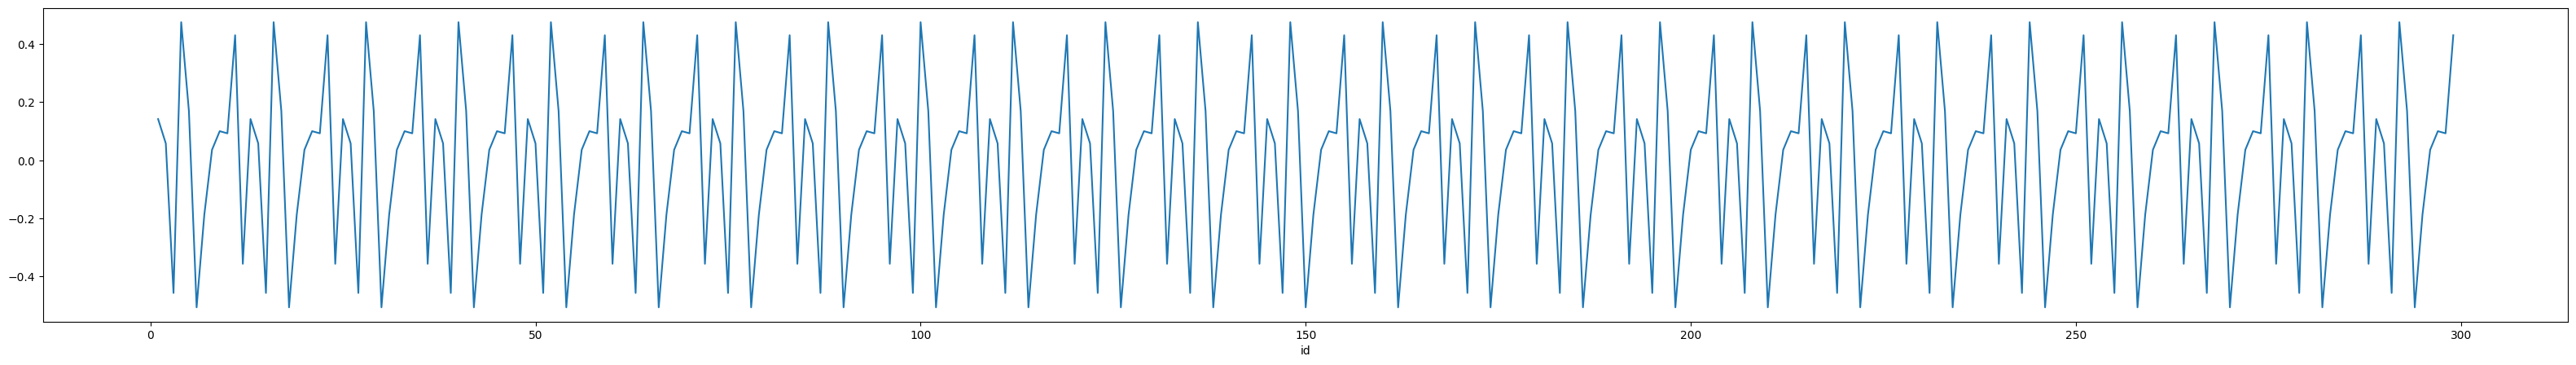

In [51]:
s.seasonal.plot(figsize=(40,5))

<Axes: xlabel='id'>

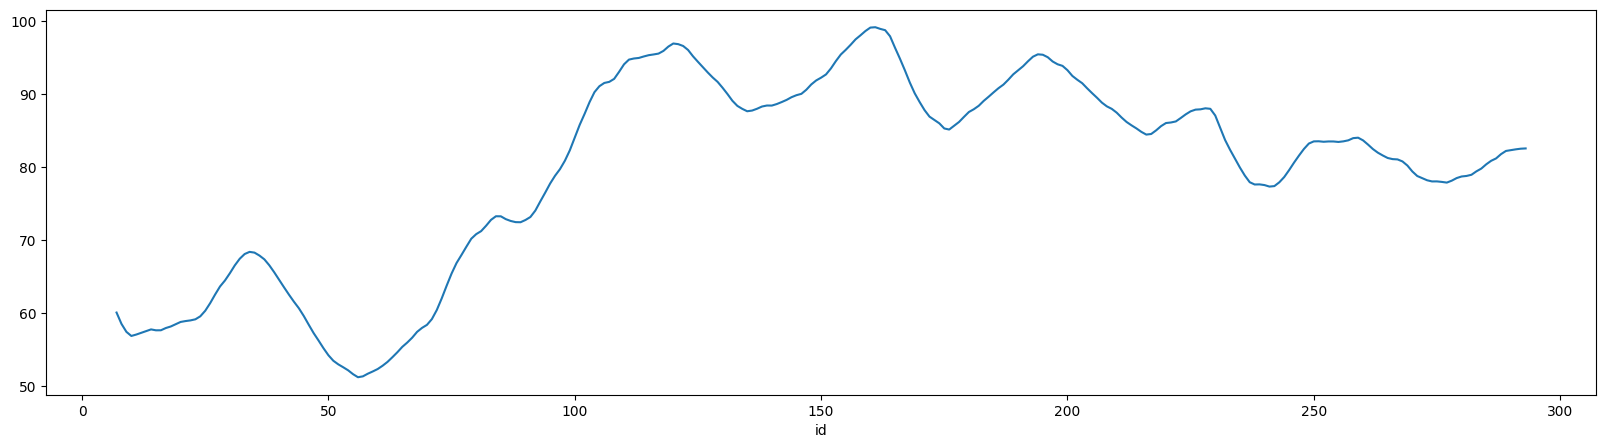

In [52]:
s.trend.plot(figsize=(20,5))

<Axes: xlabel='id'>

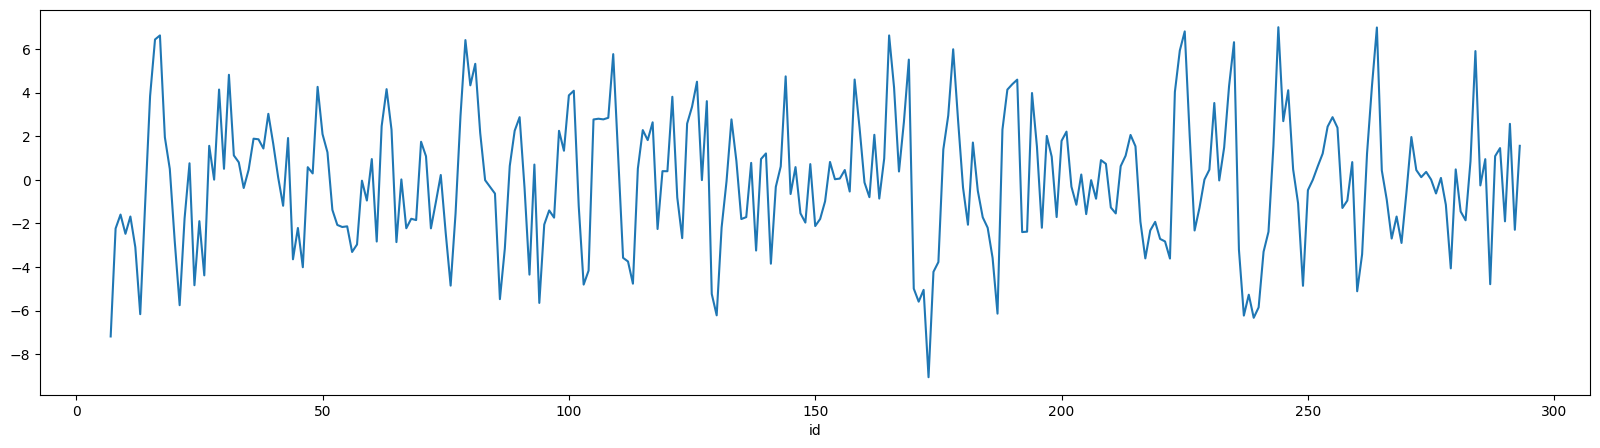

In [53]:
s.resid.plot(figsize=(20,5))

In [54]:
s = sm.tsa.seasonal_decompose(train.differenced_values, period=12)

<Axes: xlabel='id'>

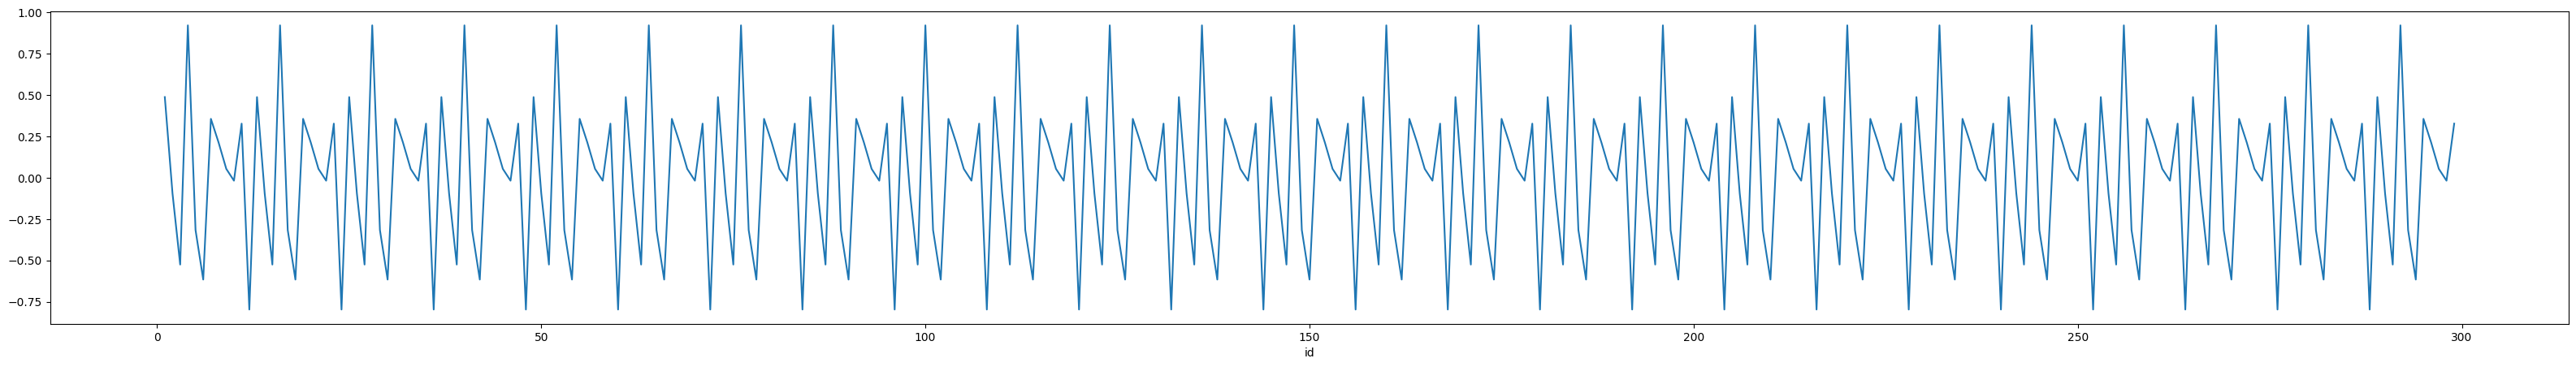

In [55]:
s.seasonal.plot(figsize=(40,5))

<Axes: xlabel='id'>

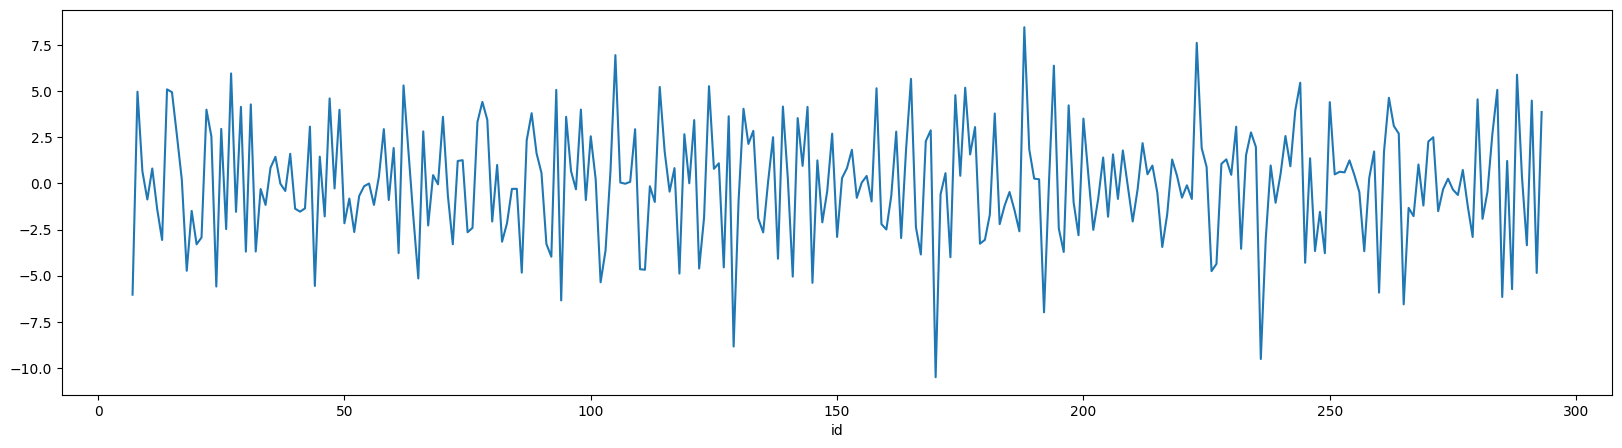

In [56]:
s.resid.plot(figsize=(20,5))

# **ARIMAX Model**

In [57]:
# train.columns
test.columns

Index(['Date', 'Open', 'Volume', 'logVolume'], dtype='object')

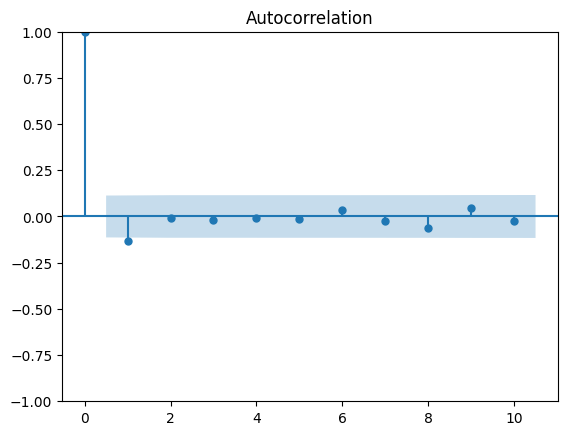

In [58]:
plot_acf(train.differenced_values,lags=10)
plt.show()

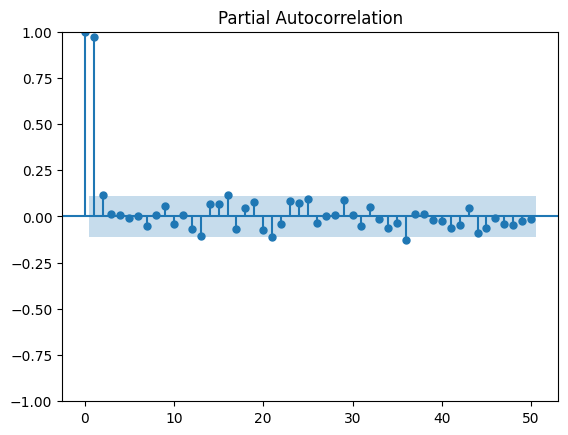

In [59]:
plot_pacf(train.Close,lags=50)
plt.show()

Here, we define an algorithm which takes in a range of values of p, d, q and calculates the AIC metric on a vanilla ARIMA model.

The Akaike Information Criterion (AIC) is a statistical measure used for model selection and comparison in the context of regression analysis and time series modeling.

AIC quantifies the trade-off between a model's goodness of fit and its complexity, penalizing models with too many parameters. It is employed to choose the best-fitting model among a set of candidate models. The model with the lowest AIC value is typically preferred because it represents a good balance between explaining the data and avoiding overfitting.

In [60]:
#Finding the best value for ARIMA
import warnings
warnings.filterwarnings("ignore")

import itertools 
p=q=range (0,4)
d = range(0,3)
pdq = list(itertools.product (p, d, q))

store = {}
for param in pdq:
       try:
              model_arima = sm.tsa.arima.ARIMA (train.Close, order = param)
              model_arima_fit = model_arima.fit()
              store[param] =  model_arima_fit.aic  
              #print(param, model_arima_fit.aic)
       except:
              continue
          
sorted_dict = dict(sorted(store.items(), key=lambda item: item[1]))
print(sorted_dict)
# The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of
# statistical models for a given set of data
# It's like the mean squared error in Regression - The smaller the number, the better

{(0, 1, 1): 1549.6714274633773, (1, 1, 0): 1549.8750065440972, (1, 1, 1): 1551.5796183562616, (0, 1, 2): 1551.6174796533837, (2, 1, 0): 1551.7041909870034, (2, 1, 1): 1552.5539274657297, (1, 1, 2): 1552.5731448095685, (0, 1, 0): 1553.1303568212686, (0, 1, 3): 1553.400837442151, (0, 2, 2): 1553.4604371239807, (3, 1, 0): 1553.4878996463995, (1, 2, 1): 1553.617957098146, (2, 1, 2): 1554.5529037971407, (3, 1, 1): 1554.5530634924016, (1, 1, 3): 1554.5563996980086, (3, 2, 3): 1555.108660999786, (1, 2, 2): 1555.41393320285, (0, 2, 3): 1555.4314011985555, (2, 2, 1): 1555.4908697722026, (2, 1, 3): 1556.5441820048402, (3, 1, 2): 1556.5531654480756, (3, 1, 3): 1556.5578653283721, (0, 2, 1): 1556.626034698168, (2, 2, 2): 1557.2526858574256, (3, 2, 1): 1557.3240913373274, (1, 2, 3): 1557.460371185379, (1, 0, 1): 1557.6971438874632, (2, 0, 0): 1557.769437714146, (2, 2, 3): 1558.3925689305784, (3, 2, 2): 1559.4745071830514, (2, 0, 1): 1559.6947459513115, (1, 0, 2): 1559.6953432107355, (3, 0, 0): 1559

In [61]:
# model_arima = sm.tsa.arima.ARIMA (train.Close, order = (0,1,1))

Plotting the predicted values on the train set - shows a decent prediction

In [62]:
import warnings
warnings.filterwarnings("ignore")

import itertools 
# using best non-seasonal order that we figured out while doing arima
p, d, q = 0, 1, 1
P = Q = range(0,3)
D = range(0,3)
PDQ = list(itertools.product (P, D, Q))

store = {}
for param in PDQ:
       try:
            model_sarimax = SARIMAX(train.Close, order = (p, d, q), seasonal_order = (param[0], param[1], param[2], 4))
            model_sarimax_fit = model_sarimax.fit(disp=False)
            store[param] =  model_sarimax_fit.aic
#             print(param, model_arima_fit.aic)
       except Exception as e:
              print(e)
          
sorted_dict = dict(sorted(store.items(), key=lambda item: item[1]))
print(sorted_dict)

{(2, 0, 2): 1544.8734642268998, (0, 0, 0): 1549.6714274633773, (1, 0, 2): 1550.465435097698, (2, 0, 1): 1550.5082483755148, (1, 1, 2): 1551.469969379043, (0, 0, 1): 1551.5505665008482, (1, 0, 0): 1551.5660588930941, (0, 1, 1): 1551.5780583257142, (2, 0, 0): 1552.300235234413, (2, 1, 2): 1552.410243801522, (0, 0, 2): 1552.5192843218751, (1, 0, 1): 1553.4283719071975, (0, 1, 2): 1553.5101427903692, (1, 1, 1): 1553.5201153794703, (2, 1, 1): 1553.889419479509, (0, 2, 2): 1573.6409455168211, (2, 2, 2): 1573.9634695048658, (1, 2, 2): 1575.3191135237814, (2, 1, 0): 1613.3636698018088, (2, 2, 1): 1620.312701722796, (1, 1, 0): 1664.4242188240119, (1, 2, 1): 1668.018077850803, (0, 2, 1): 1734.616487615171, (0, 1, 0): 1735.0890238388831, (2, 2, 0): 1788.6322871444374, (1, 2, 0): 1883.7984211130038, (0, 2, 0): 2020.8478987354}


In [63]:

model_sarimax = SARIMAX(train.Close, order = (0, 1, 1), seasonal_order = (2, 0, 2, 10))
model_sarimax_fit = model_sarimax.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58108D+00    |proj g|=  3.17184D-02


 This problem is unconstrained.



At iterate    5    f=  2.58027D+00    |proj g|=  8.16949D-03

At iterate   10    f=  2.57817D+00    |proj g|=  1.73061D-02

At iterate   15    f=  2.57684D+00    |proj g|=  1.05341D-03

At iterate   20    f=  2.57674D+00    |proj g|=  1.10418D-03

At iterate   25    f=  2.57670D+00    |proj g|=  2.43847D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   2.619D-06   2.577D+00
  F =   2.5767044922157960     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


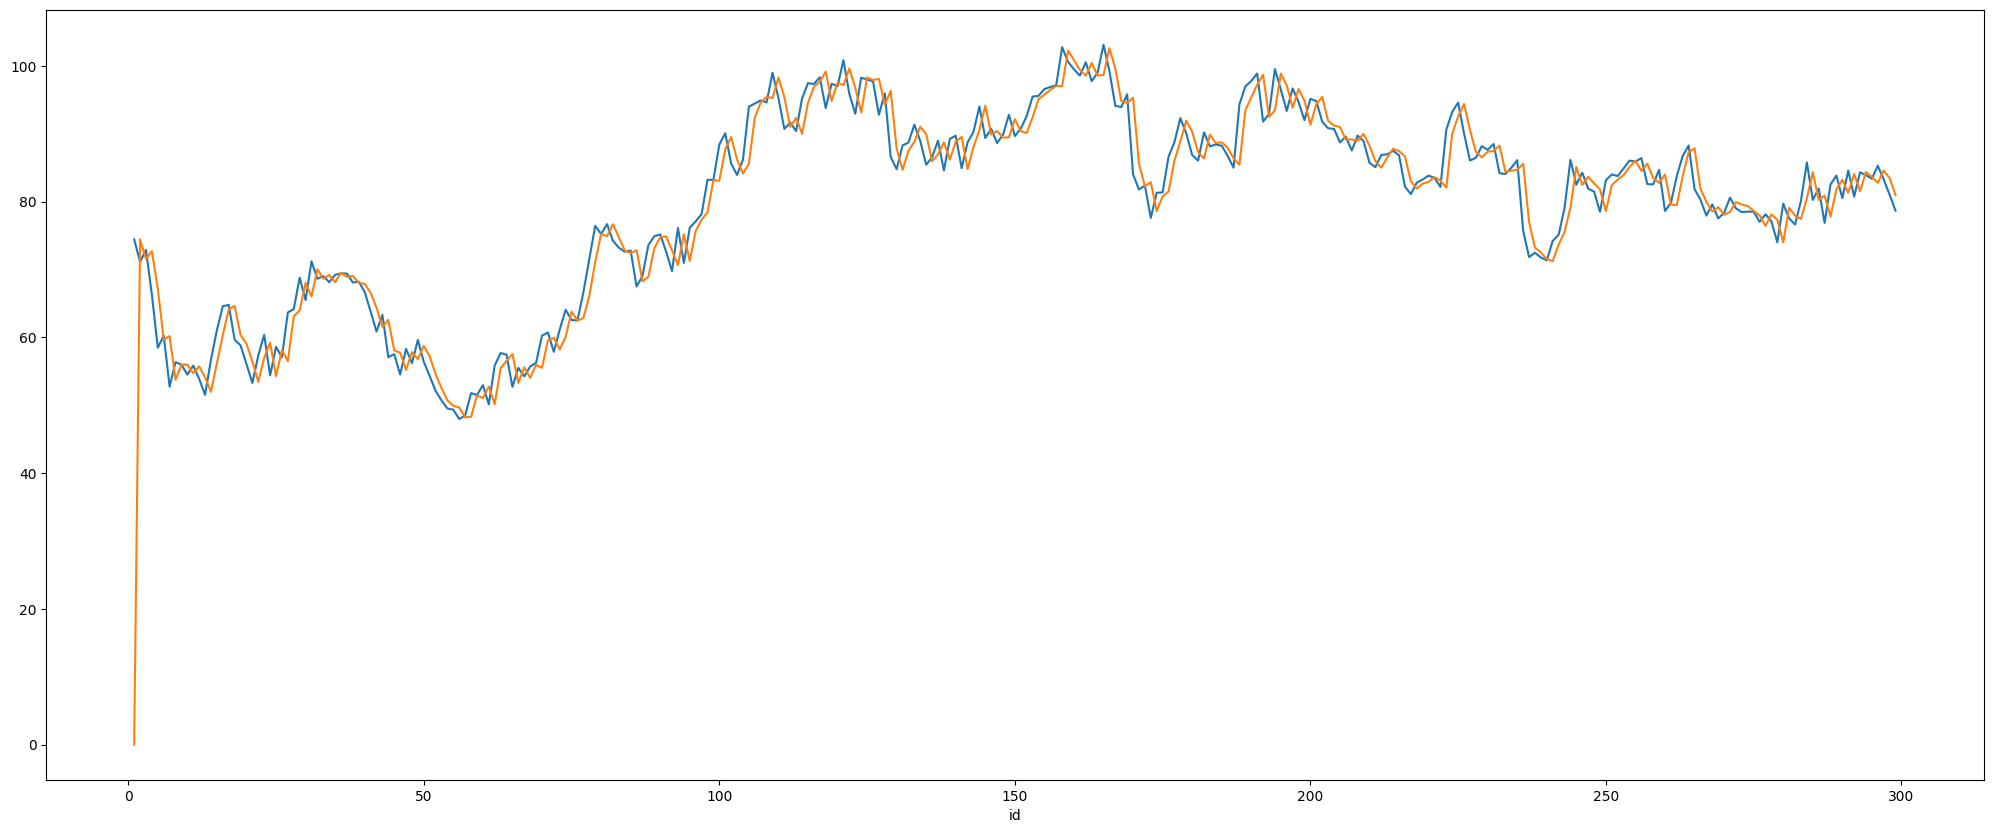

In [64]:
train['Close'].plot(figsize=(25,10))
# test['Close'].plot()
model_sarimax_fit.fittedvalues.plot()
plt.show()

In [65]:
# train['Open'].plot(figsize=(25,10))
# test['Open'].plot(figsize=(25,10))
# plt.xlabel('Date')

With this piece of code, we shall perform model inference. We'll use our hold-out test set for this. Using the exogenous variables, we'll provide input into our fitted ARIMAX model, and obtain the predcitions for power_consumed

In [66]:
attrs = ['Open','Volume','Close_Lag_1','Close_Lag_2','SMA_4','SMA_12','Volatility_4','RSI','MACD','Upper_Band','Lower_Band','Close_vs_SMA_4','Close_vs_SMA_12','Price_RoC_4','Price_RoC_12','Open_Close_Corr']
# predict = model_sarimax_fit.predict(start = len(train),end = len(train) + len(test) - 1,exog = sm.add_constant(train[attrs]))
predict = model_sarimax_fit.predict(start = len(train),end = len(train) + len(test) - 1,exog = sm.add_constant(train[attrs]), dynamic=True)

test['Close'] = predict.values
print(len(predict))
print(len(test['Open']))
# # test['predicted'] = predict.values
# # test.tail(5)

# y_pred = np.array(predict.values)
# y_true = np.array(train['Close'])

100
100


In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# features = ['Open', 'Close', 'Volume']
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)  # You can adjust hyperparameters as needed

label_encoder = LabelEncoder()
res = label_encoder.fit_transform(train['Strategy'])
rf_model.fit(train[['Open', 'Close', 'Volume']], res)

rf_model_pred = rf_model.predict(test[['Open', 'Close', 'Volume']])
y_pred_decoded = label_encoder.inverse_transform(rf_model_pred)
print(y_pred_decoded)


['Buy' 'Buy' 'Buy' 'Buy' 'Hold' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy'
 'Hold' 'Hold' 'Hold' 'Buy' 'Hold' 'Sell' 'Buy' 'Hold' 'Buy' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Buy' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Buy' 'Hold' 'Buy' 'Hold' 'Buy' 'Buy' 'Buy' 'Hold' 'Hold'
 'Buy' 'Sell' 'Buy' 'Buy' 'Buy' 'Buy' 'Hold' 'Hold' 'Buy' 'Buy' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Hold' 'Buy' 'Buy' 'Hold' 'Buy'
 'Hold' 'Hold' 'Sell' 'Hold' 'Hold' 'Hold' 'Sell' 'Hold' 'Sell' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Sell' 'Sell' 'Hold' 'Hold' 'Sell' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Sell' 'Hold' 'Sell' 'Hold' 'Hold' 'Hold'
 'Sell' 'Sell' 'Hold' 'Hold']


In [68]:
# import xgboost as xgb
# from sklearn.preprocessing import LabelEncoder

# # features = ['Open', 'Close', 'logVolume']
# xg_model = xgb.XGBClassifier(objective="multi:softmax", num_class=3)
# label_encoder = LabelEncoder()
# res = label_encoder.fit_transform(train['Strategy'])
# xg_model.fit(train[['Open', 'Close', 'Volume']], res)

# xg_model_pred = xg_model.predict(test[['Open', 'Close', 'Volume']])
# y_pred_decoded = label_encoder.inverse_transform(xg_model_pred)
# print(y_pred_decoded)

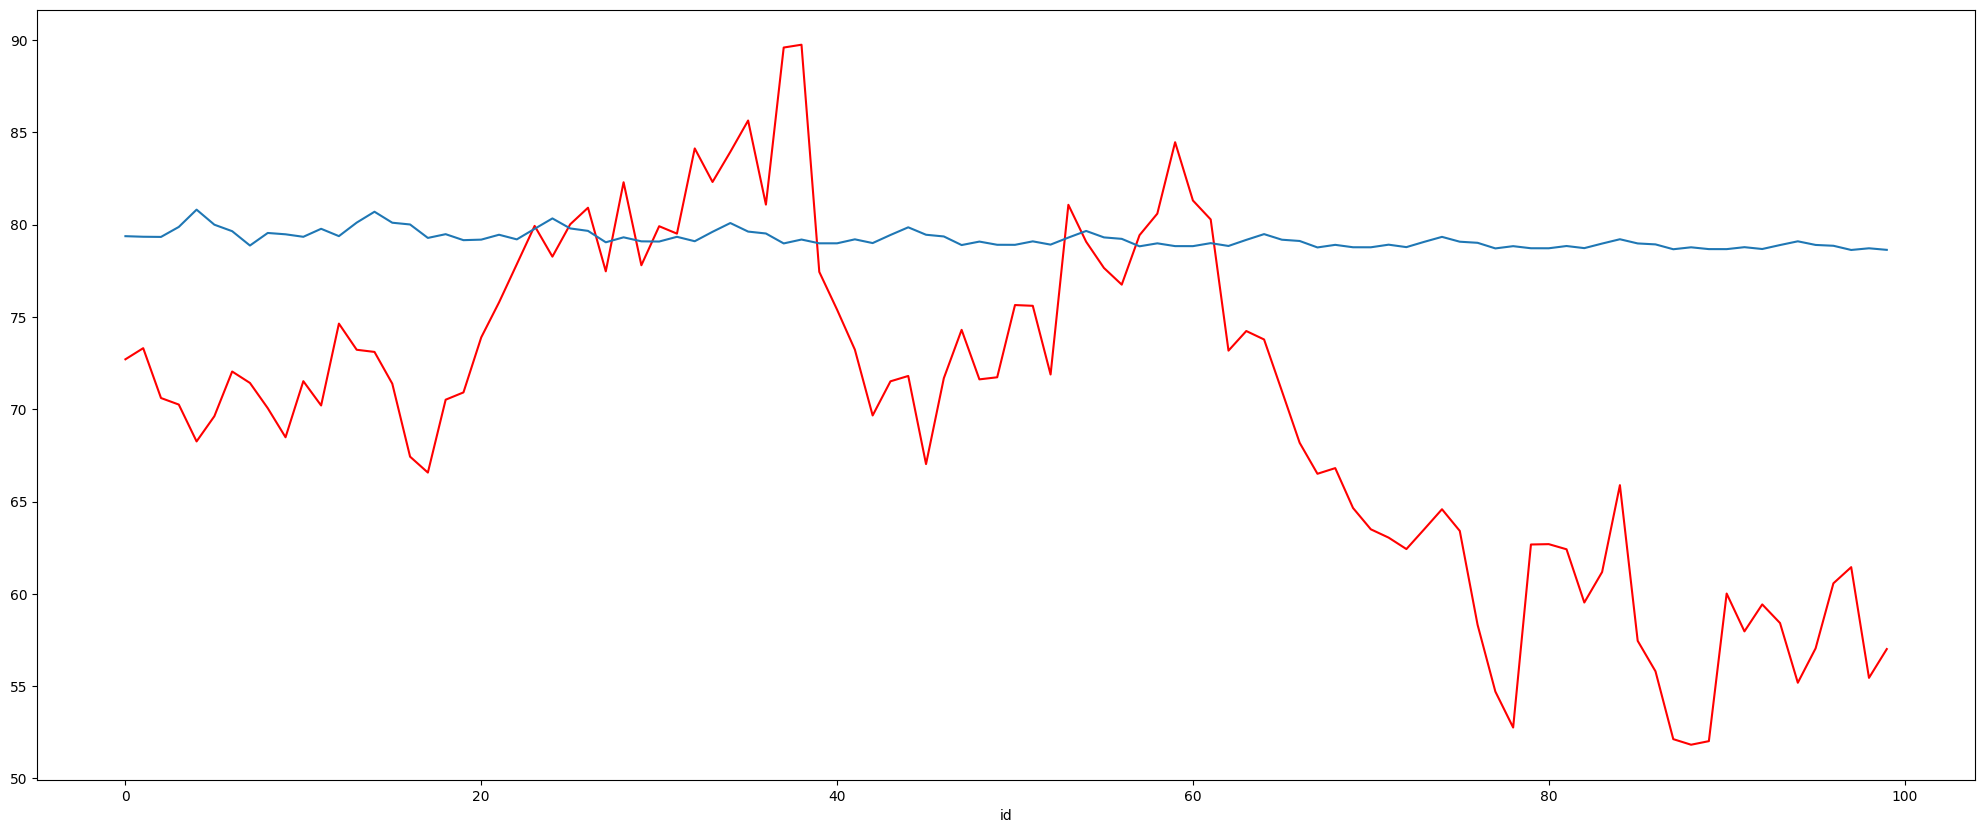

In [69]:
test['Open'].plot(figsize=(25,10), color="red")
test['Close'].plot(figsize=(25,10))
plt.show()

# Your model creation, training and inferencing code, along with suitable analysis and reasoning!

In [70]:
submission = pd.DataFrame()
submission["Date"] = test["Date"]
submission["Close"] = test["Close"]
submission["Strategy"] = y_pred_decoded

In [71]:
# sample_submission = pd.read_csv('/kaggle/input/ue21cs342aa2/sample_submission.csv', index_col = 0)

In [72]:
# submission["Close"] = sample_submission["Close"]
# submission["Strategy"] = sample_submission["Strategy"]

### In the cell above, we have just provided an example of how to create your submission DataFrame. Please make sure to use **your own forecasts and predictions**, in place of `sample_submission["Close"]` and `sample_submission["Strategy"]`

In [73]:
submission.head()

,Date,Close,Strategy
id,,,
0,2021-03-01,79.379207,Buy
1,2021-03-08,79.348151,Buy
2,2021-03-15,79.338915,Buy
3,2021-03-22,79.879459,Buy
4,2021-03-29,80.816095,Hold


In [74]:
submission.to_csv('submission.csv', index=True)